# 3D Atom Pair fingerprints in the RDKit

The option to generate 3D atom pair fingerprints by using the molecule's 3D distance matrix instead of the 2D distance matrix has recently been added to the RDKit. The idea is similar to (though not as thorougly developed) as the (DiP)

The goal here is to probe the behavior of these new fingerprints.

In [1]:
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import AllChem
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import py3Dmol
from rdkit.Chem import Draw
import rdkit
print(rdkit.__version__)
%pylab inline
plt.style.use('tableau-colorblind10')


2022.09.4
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Generate fingerprints for some literature compounds

These are some aligned Factor XA ligand structures from the Giangreco overlays set (https://pubs.acs.org/doi/10.1021/ci400020a).

In [2]:
fxa_ms = [x for x in Chem.SDMolSupplier('/scratch/cheminformatics_datasets/AZ_overlays/P00742.sdf') if x is not None]


The molecules in these datasets are pre-overlayed. :-)

In [3]:
v = py3Dmol.view(width=350,height=350)
v.removeAllModels()
for i in range(1,10):
    IPythonConsole.addMolToView(fxa_ms[i],v)
v.zoomTo()
v.show()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

We generate atom pair fingerprints using 3D distances instead of topological distances by setting `use2D=False`:

In [4]:
fpg = rdFingerprintGenerator.GetAtomPairGenerator(use2D=False)
fxa_fps = [fpg.GetSparseCountFingerprint(x) for x in fxa_ms]

In [5]:
len(fxa_fps)

37

We want to look at similarity distributions.

There are too many of those to look at all the pairs, so we'll pick 25K random pairs:

In [6]:
fxa3d_ds = []
for i in range(len(fxa_fps)):
    fxa3d_ds.extend(DataStructs.BulkDiceSimilarity(fxa_fps[i],fxa_fps[i+1:]))


And then generate a histogram of those distances

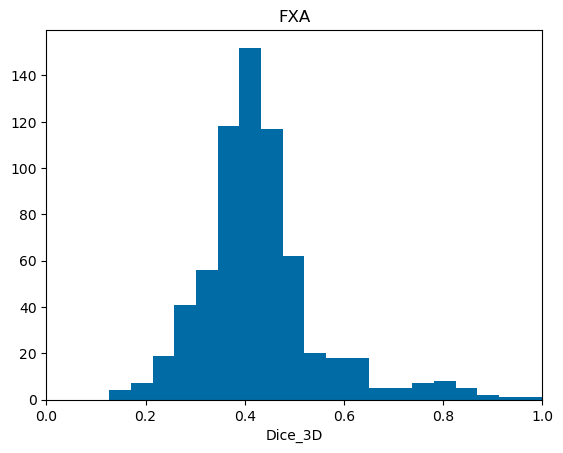

In [7]:
hist(fxa3d_ds,bins=20)
xlim((0,1.0))
xlabel('Dice_3D')
title('FXA');

Repeat the above for some DPP4 ligands:

Here is the code for reading the target information from uniprot and constructing the intake data description:
```

import glob
import requests

# obsolete entries
remap = {'P0C5C1':'P9WKD2','P0A5J2':'P9WK18'}

pinfo = {}
for fn in glob.glob('/scratch/cheminformatics_datasets/AZ_overlays/*.sdf'):
    k = fn.split('/')[-1][:-4]
    splitk = k.split('_')
    if splitk:
        nk = splitk[0]
    else:
        nk = k
    if nk in remap:
        unip = remap[nk]
    else:
        unip = nk
    if k in pinfo:
        continue
    r = requests.get(f'https://www.ebi.ac.uk/proteins/api/proteins/{unip}')
    info = r.json()
    pid = info['id']
    pname = 'N/A'
    if 'recommendedName' in info['protein']:
        pname = info['protein']['recommendedName']['fullName']['value']
    elif 'submittedName' in info['protein']:
        pname = info['protein']['submittedName'][0]['fullName']['value']
        
    tmp = [x for x in Chem.SDMolSupplier(fn) if x is not None]
    pinfo[k] = (pid,pname,len(tmp))
    print(pinfo[k])

yaml = []
for access,v in pinfo.items():
    fn,pid,nm,sz = v
    md = f'''    {fn}:
      description: aligned ligands from {pid}
      args:
        filename: '{{{{ CATALOG_DIR }}}}/AZ_overlays/{fn}.sdf'
      driver: intake_rdkit.sdf.SDFSource
      metadata:
        protein_uniprot_id: {pid}
        protein_uniprot_accession: {access}
        protein_uniprot_nm: {nm}
        protein_uniprot_url: https://www.uniprot.org/uniprotkb/{access}/entry
        num_compounds: {sz}
    '''
    yaml.append(md)
print('''metadata:
  version: 1
  creator: 
    name: greg landrum
    email: glandrum@ethz.ch

  summary: |
    Collections of aligned PDB ligands from the JCIM article by Giangreco et al.
    An Extensive and Diverse Set of Molecular Overlays for the Validation of Pharmacophore Programs
    JCIM 4:852-856 (2013) https://doi.org/10.1021/ci400020a
    
  metdata:
    paper_url: https://doi.org/10.1021/ci400020a
    paper title: An Extensive and Diverse Set of Molecular Overlays for the Validation of Pharmacophore Programs

sources:''')
print('\n'.join(yaml))
```

Get our catalog:

In [176]:
import intake
catalog = intake.open_catalog('/scratch/cheminformatics_datasets/az_overlays.yaml')
ds = catalog['P61823'].get(removeHs=False) # get a version of the datasource which does not remove Hs

df =ds.read()

In [177]:
Chem.MolToSmiles(df.mol[0])

'[H]OC([H])([H])[C@@]1([H])O[C@@]([H])(n2c([H])c([H])c(=O)n([H])c2=O)[C@]([H])(F)[C@]1([H])OP(=O)([O-])[O-]'

Interesting ones: `('kapca','P00517')`

In [182]:
mols_h = {}
mols = {}
for nm,fn in [('fxa','P00742'),
             ('dpp4','P27487'),
             ('cdk2','P24941'),
             ('hs90a','P07900'),
             ('mk14','Q16539'),]:
    mols_h[nm] = [x for x in catalog[fn].get(removeHs=False).read().mol  
                   if x is not None]
    mols[nm] = [Chem.RemoveHs(x) for x in mols_h[nm]]

fpg = rdFingerprintGenerator.GetAtomPairGenerator(use2D=False)
fpg2d = rdFingerprintGenerator.GetAtomPairGenerator(use2D=True)
fps_h = {}
fps = {}
fps_2d = {}
fps_2d_h = {}
for k,mh in mols_h.items():
    fps_h[k] = [fpg.GetSparseCountFingerprint(x) for x in mh]
    fps[k] = [fpg.GetSparseCountFingerprint(x) for x in mols[k]]
    fps_2d[k] = [fpg2d.GetSparseCountFingerprint(x) for x in mols[k]]
    fps_2d_h[k] = [fpg2d.GetSparseCountFingerprint(x) for x in mh]
    
    
sims_h = {}
sims = {}
sims_2d = {}
sims_2d_h = {}
for k,fpl in fps_h.items():
    ds = []
    for i in range(len(fpl)): ds.extend(DataStructs.BulkDiceSimilarity(fpl[i],fpl[i+1:]))
    sims_h[k] = ds
    
    fpl = fps[k]
    ds = []
    for i in range(len(fpl)): ds.extend(DataStructs.BulkDiceSimilarity(fpl[i],fpl[i+1:]))
    sims[k] = ds
    
    fpl = fps_2d[k]
    ds = []
    for i in range(len(fpl)): ds.extend(DataStructs.BulkDiceSimilarity(fpl[i],fpl[i+1:]))
    sims_2d[k] = ds

    fpl = fps_2d_h[k]
    ds = []
    for i in range(len(fpl)): ds.extend(DataStructs.BulkDiceSimilarity(fpl[i],fpl[i+1:]))
    sims_2d_h[k] = ds


[04:52:19] Explicit valence for atom # 21 C, 5, is greater than permitted
[04:52:19] ERROR: Could not sanitize molecule ending on line 1352
[04:52:19] ERROR: Explicit valence for atom # 21 C, 5, is greater than permitted
[04:52:19] Explicit valence for atom # 13 N, 4, is greater than permitted
[04:52:19] ERROR: Could not sanitize molecule ending on line 894
[04:52:19] ERROR: Explicit valence for atom # 13 N, 4, is greater than permitted


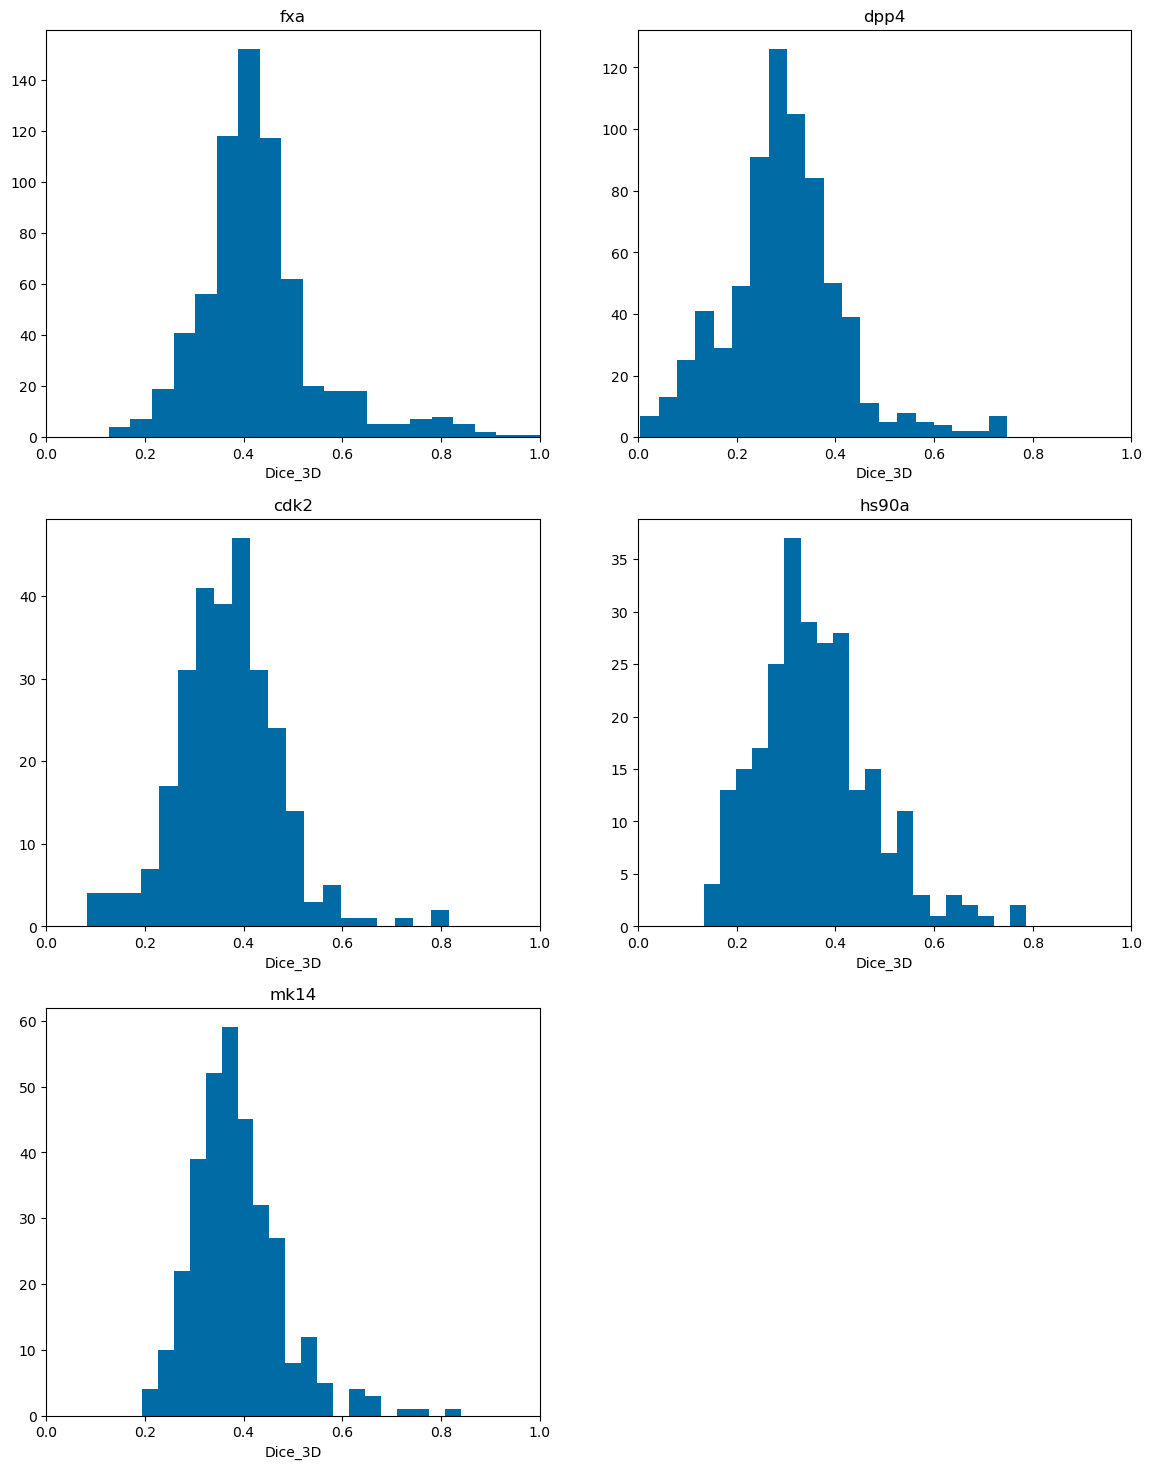

In [183]:
ncols = 2
nrows = len(sims)//ncols
if len(sims) % ncols:
    nrows += 1

figsize(7*ncols,6*nrows)
for i,k in enumerate(sims):
    subplot(nrows,ncols,i+1)
    hist(sims[k],bins=20)
    xlim((0,1.0))
    xlabel('Dice_3D')
    title(k)

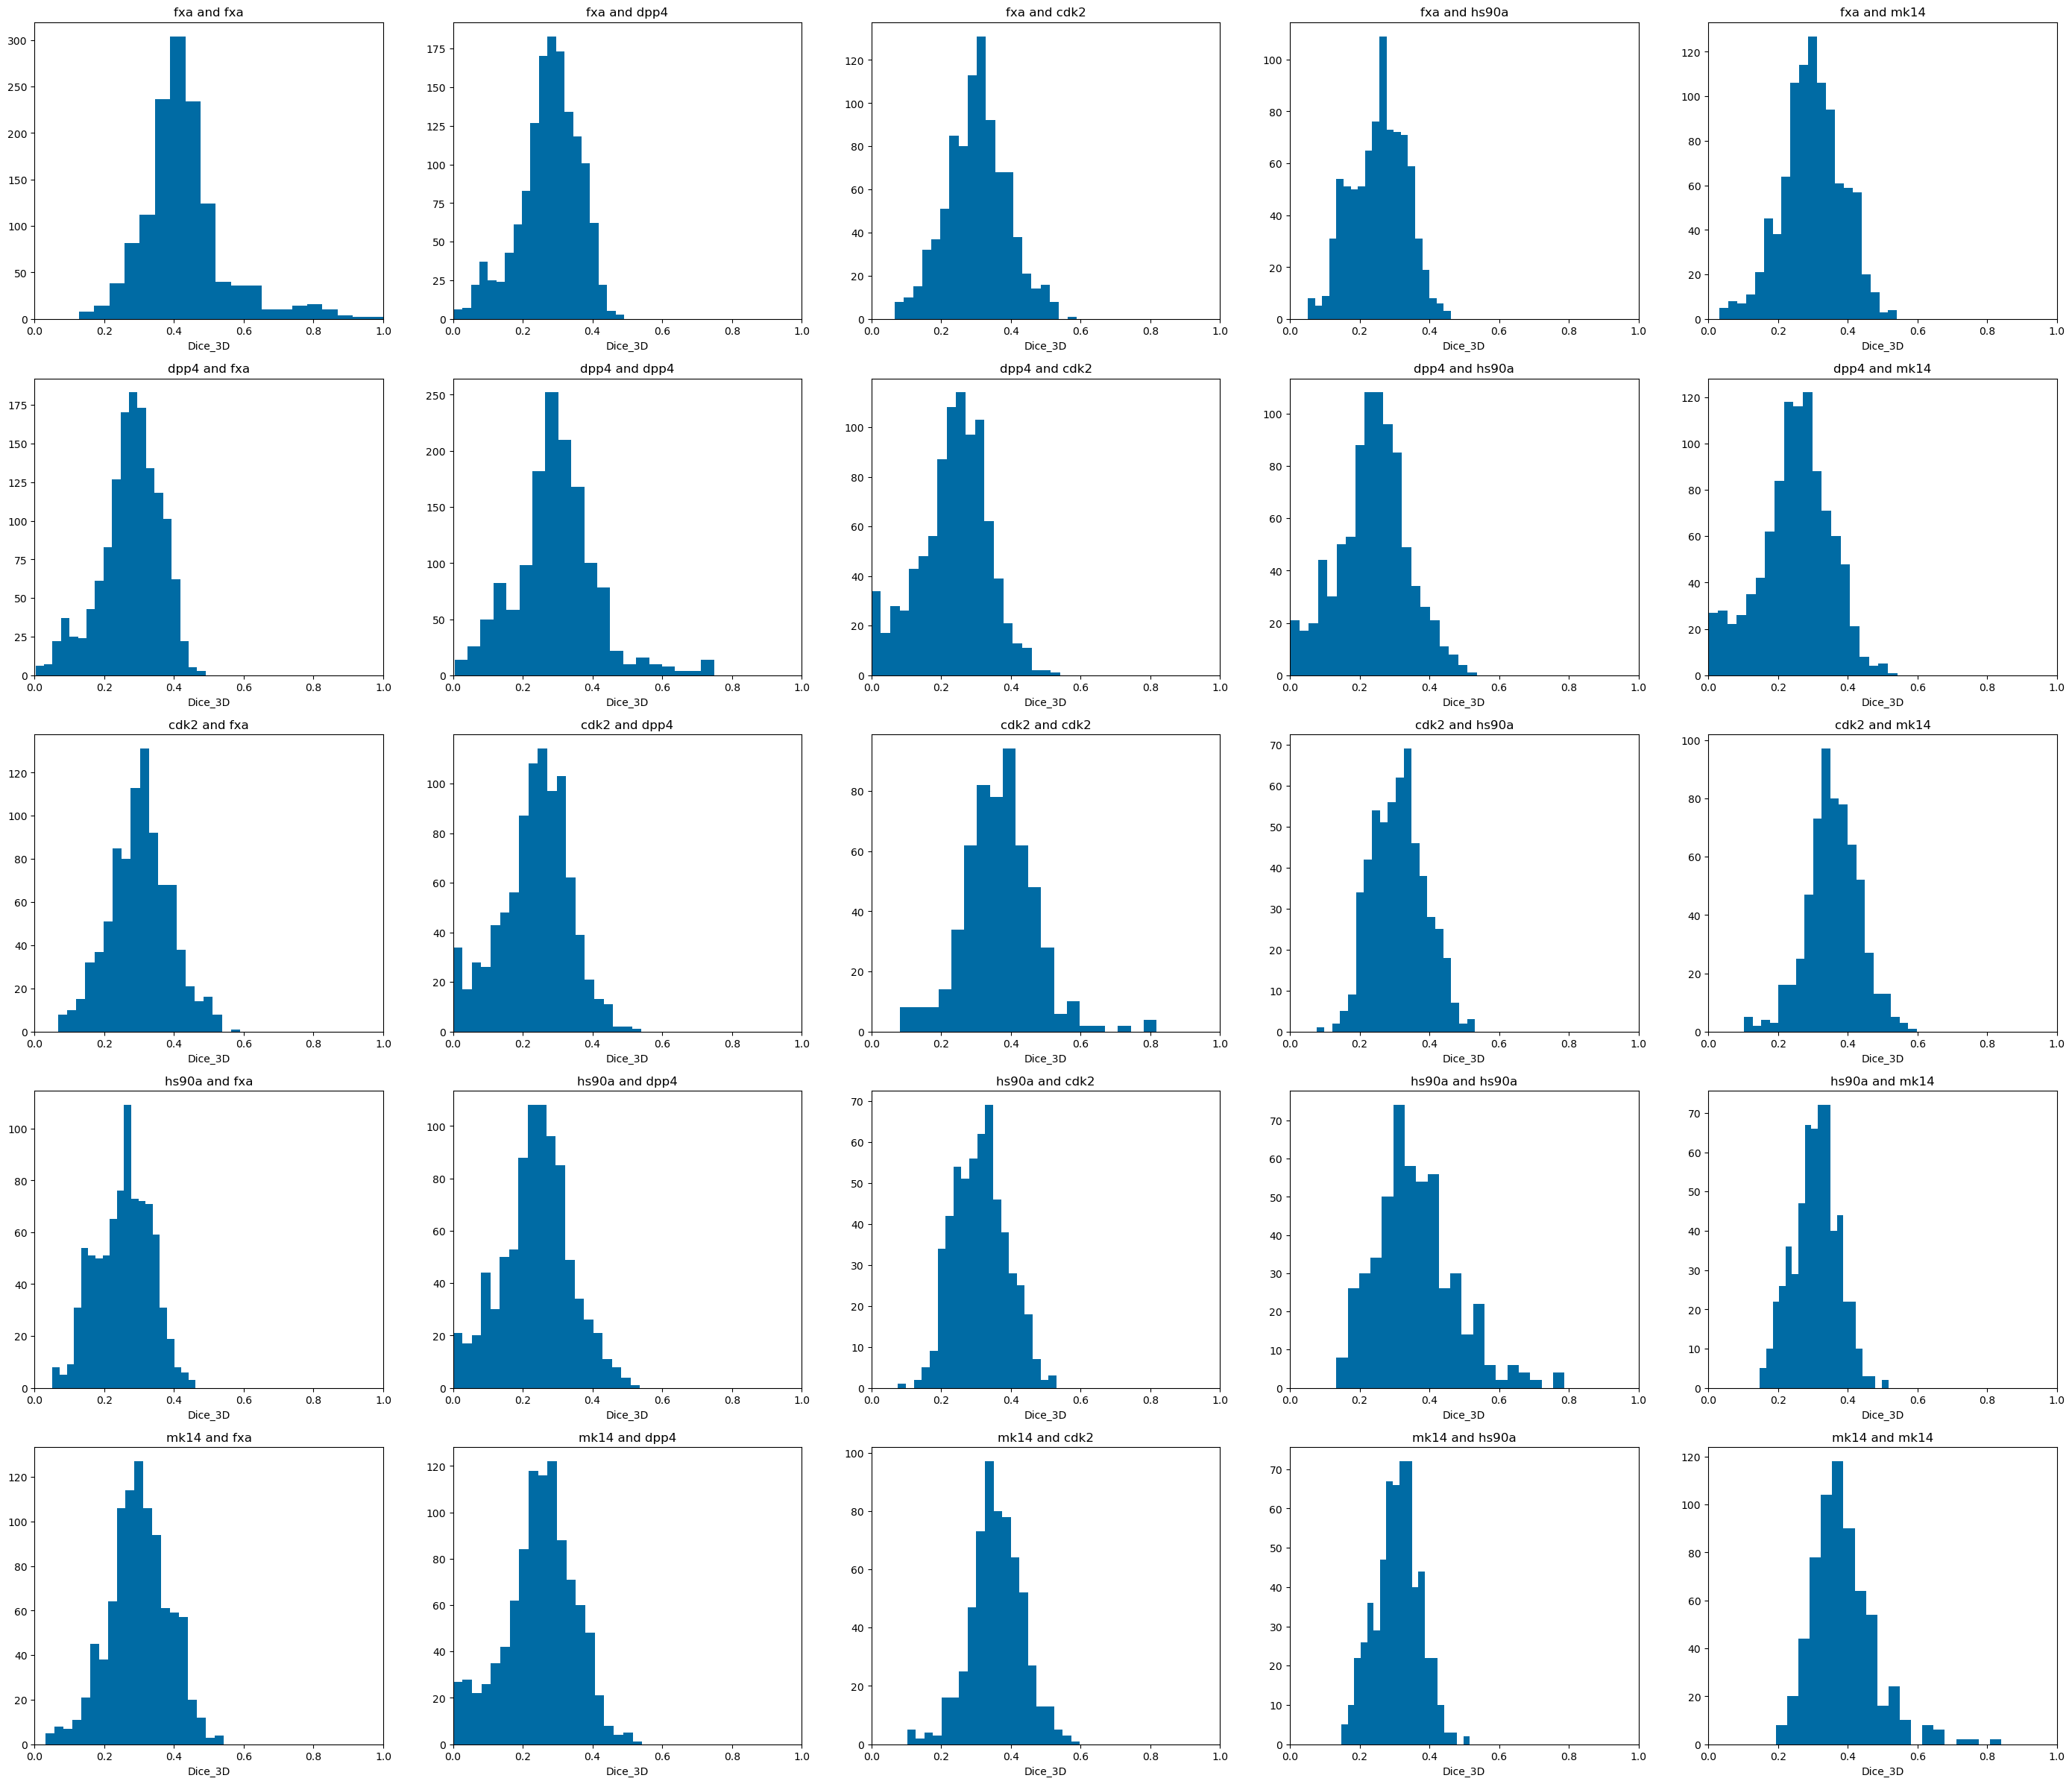

In [184]:
ncols = len(sims)
nrows = len(sims)

figsize(7*ncols,6*nrows)
idx = 0
for k1 in sims:
    for k2 in sims:
        idx += 1
        subplot(nrows,ncols,idx)
        ds = []
        for i,fpi in enumerate(fps[k1]): 
            if k1 != k2:
                ds.extend(DataStructs.BulkDiceSimilarity(fpi,fps[k2]))
            else:
                # remove self terms
                ds.extend(DataStructs.BulkDiceSimilarity(fpi,fps[k2][:i]+fps[k2][i+1:]))
            
        hist(ds,bins=20)
        xlim((0,1.0))
        xlabel('Dice_3D')
        title(f'{k1} and {k2}')

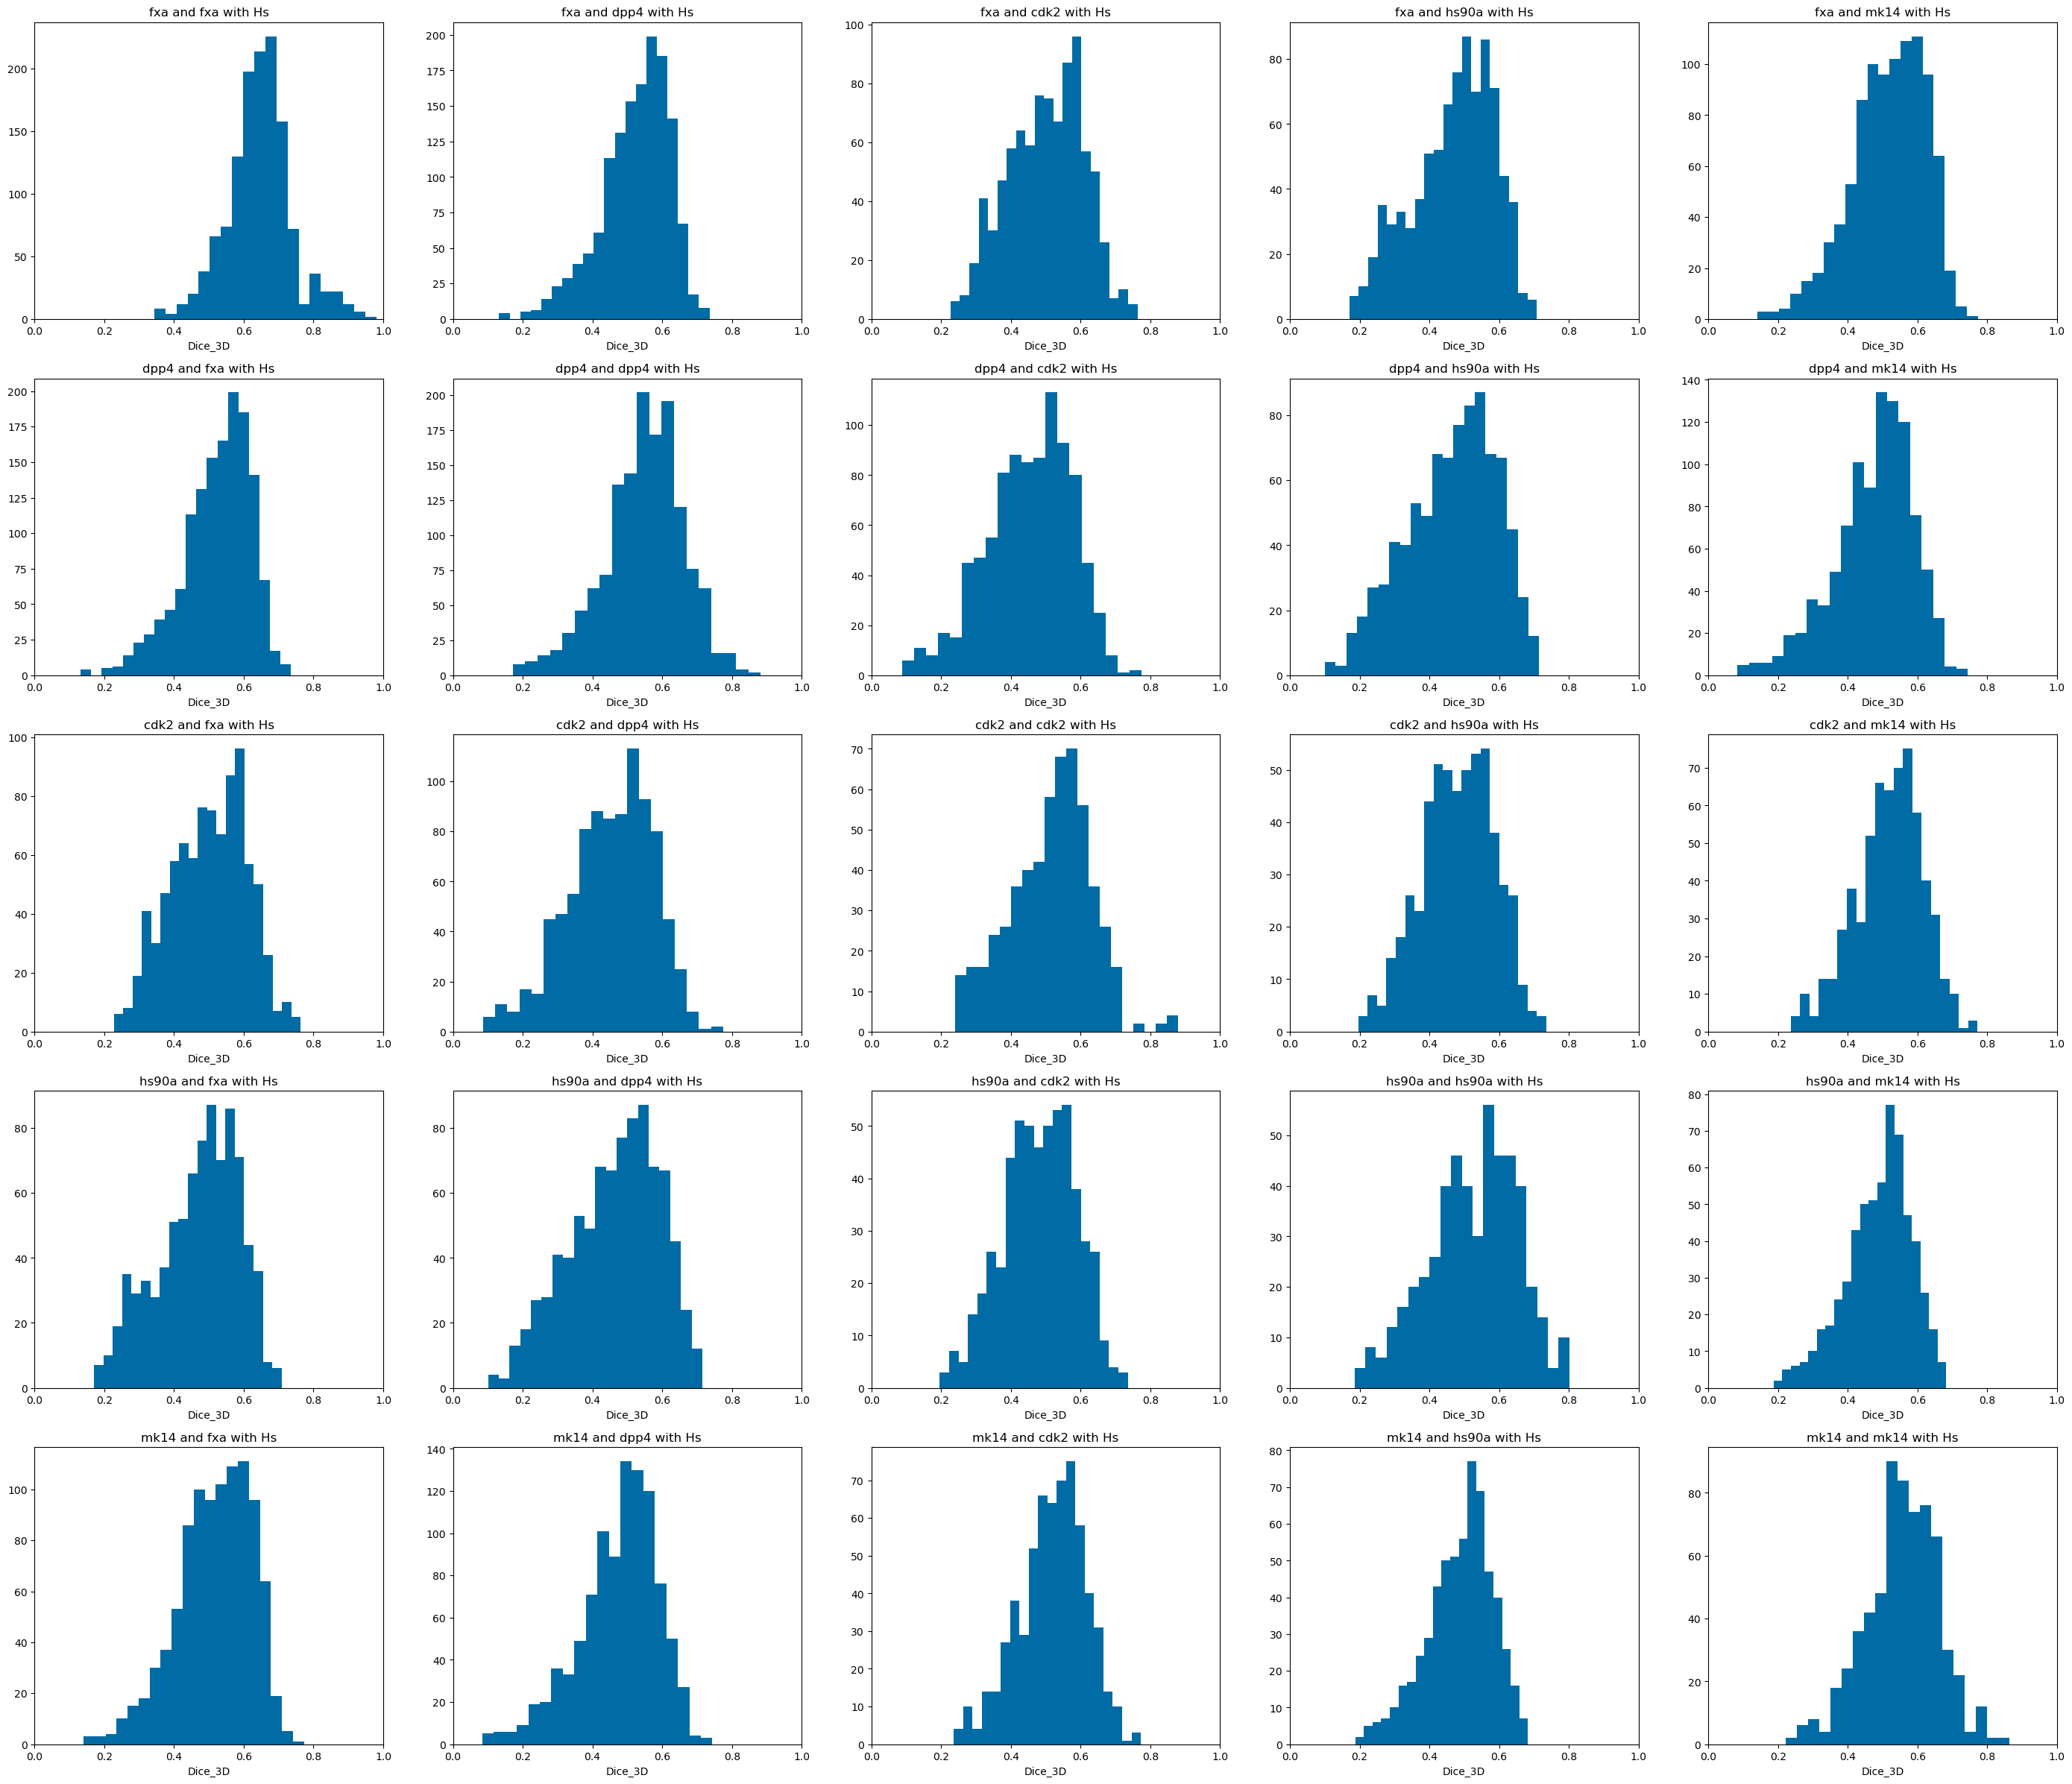

In [186]:
ncols = len(sims)
nrows = len(sims)

figsize(7*ncols,6*nrows)
idx = 0
for k1 in sims_h:
    for k2 in sims_h:
        idx += 1
        subplot(nrows,ncols,idx)
        ds = []
        for i,fpi in enumerate(fps_h[k1]): 
            if k1 != k2:
                ds.extend(DataStructs.BulkDiceSimilarity(fpi,fps_h[k2]))
            else:
                # remove self terms
                ds.extend(DataStructs.BulkDiceSimilarity(fpi,fps_h[k2][:i]+fps_h[k2][i+1:]))
            
        hist(ds,bins=20)
        xlim((0,1.0))
        xlabel('Dice_3D')
        title(f'{k1} and {k2} with Hs')

Direct comparison with/without Hs

fxa spearman: 0.787
dpp4 spearman: 0.807
cdk2 spearman: 0.766
hs90a spearman: 0.824
mk14 spearman: 0.716


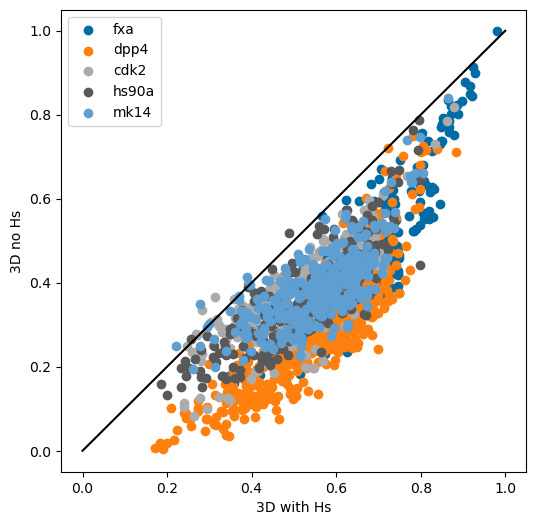

In [187]:
from scipy import stats
figsize(6,6)
for k1,v1 in sims.items():
    v2 = sims_h[k1]
    scatter(v2,v1,label=k1)
    print(f'{k1} spearman: {stats.spearmanr(v1,v2)[0]:.3f}')
xlabel('3D with Hs')
ylabel('3D no Hs')
plot((0,1),(0,1),'k-')
legend();

And the 2D version, again with and without Hs

fxa spearman: 0.784
dpp4 spearman: 0.810
cdk2 spearman: 0.797
hs90a spearman: 0.832
mk14 spearman: 0.735


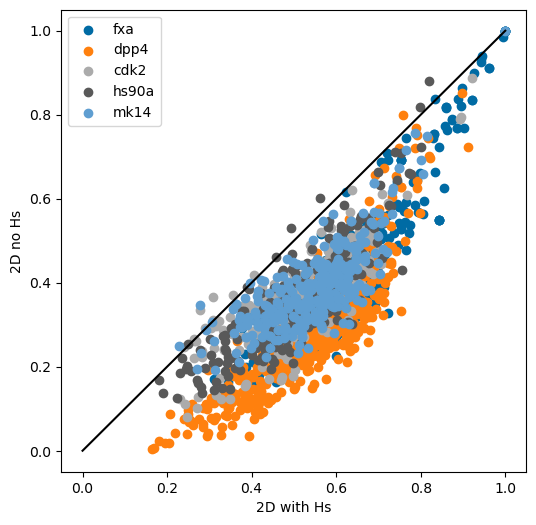

In [188]:
from scipy import stats
figsize(6,6)
for k1,v1 in sims_2d.items():
    v2 = sims_2d_h[k1]
    scatter(v2,v1,label=k1)
    print(f'{k1} spearman: {stats.spearmanr(v1,v2)[0]:.3f}')
xlabel('2D with Hs')
ylabel('2D no Hs')
plot((0,1),(0,1),'k-')
legend();

2D vs 3D

fxa spearman R: 0.956
dpp4 spearman R: 0.970
cdk2 spearman R: 0.980
hs90a spearman R: 0.974
mk14 spearman R: 0.967


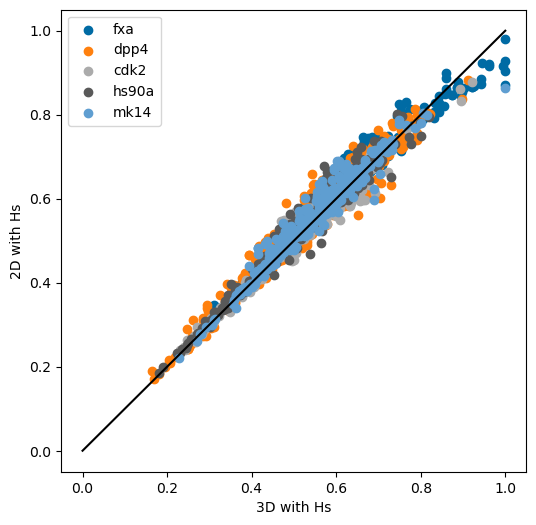

In [189]:
from scipy import stats
figsize(6,6)
for k1,v1 in sims_h.items():
    v2 = sims_2d_h[k1]
    scatter(v2,v1,label=k1)
    print(f'{k1} spearman R: {stats.spearmanr(v1,v2)[0]:.3f}')
xlabel('3D with Hs')
ylabel('2D with Hs')
plot((0,1),(0,1),'k-')
legend();

fxa spearman R: 0.932
dpp4 spearman R: 0.949
cdk2 spearman R: 0.977
hs90a spearman R: 0.969
mk14 spearman R: 0.965


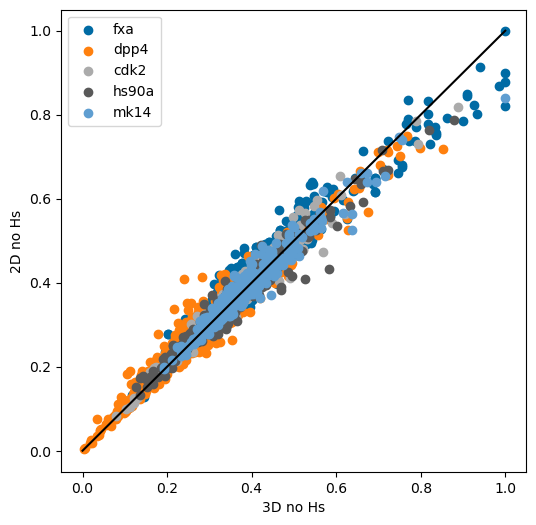

In [190]:
from scipy import stats
figsize(6,6)
for k1,v1 in sims.items():
    v2 = sims_2d[k1]
    scatter(v2,v1,label=k1)
    print(f'{k1} spearman R: {stats.spearmanr(v1,v2)[0]:.3f}')
xlabel('3D no Hs')
ylabel('2D no Hs')
plot((0,1),(0,1),'k-')
legend();

In [194]:
from rdkit.Chem import rdShapeHelpers
from rdkit.Chem import AllChem
shape_sims = {}
shape_protrudes = {}
for k1,tms in mols_h.items():
    shape_sims[k1] = []
    shape_protrudes[k1] = []
    for i,mi in enumerate(tms):
        for j in range(i+1,len(tms)):
            mj = tms[j]
            shape_protrudes[k1].append(1-AllChem.ShapeProtrudeDist(mi,mj))
            shape_sims[k1].append(1-AllChem.ShapeTanimotoDist(mi,mj))
                        

fxa spearman R: 0.371
dpp4 spearman R: 0.179
cdk2 spearman R: 0.267
hs90a spearman R: 0.425
mk14 spearman R: 0.272


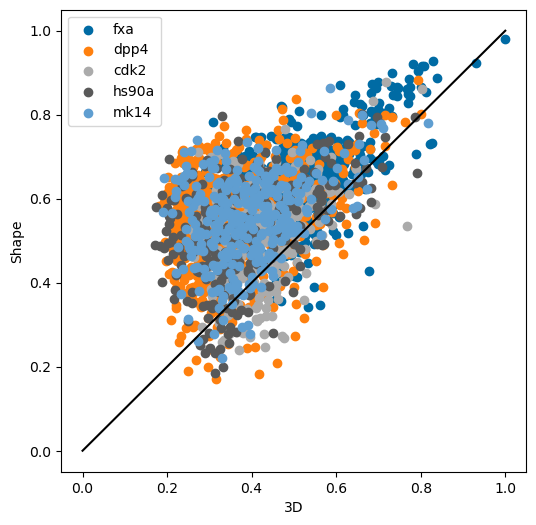

In [195]:
from scipy import stats
figsize(6,6)
for k1,v1 in sims_h.items():
    v2 = shape_sims[k1]
    scatter(v2,v1,label=k1)
    print(f'{k1} spearman R: {stats.spearmanr(v1,v2)[0]:.3f}')
xlabel('3D')
ylabel('Shape')
plot((0,1),(0,1),'k-')
legend();

Let's be sure that there actually is some 3D character to these fingerprints.

Start by picking a flexible molecule and generating a set of conformers for it:

In [166]:
nrots = [AllChem.CalcNumRotatableBonds(x) for x in mols_h['dpp4']]

In [167]:
max(nrots)

9

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

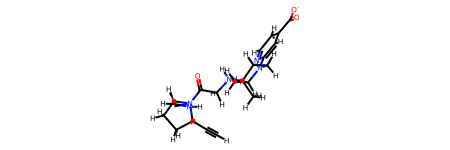

In [169]:
idx = nrots.index(8)
flex_mol = Chem.Mol(mols_h['dpp4'][9])
fm2 = Chem.Mol(flex_mol)
fm2

In [170]:
params = AllChem.ETKDGv3()
params.randomSeed = 0xf00d
params.pruneRmsThresh = 0.5
params.maxAttempts = 1000
params.numThreads = 4
flex_mol = Chem.AddHs(flex_mol)
cids = AllChem.EmbedMultipleConfs(flex_mol,50,params)
print(len(cids))


49


Now pick the conformations apart into separate molecules:

In [200]:
flex_mols=[]
flex_mols_h=[]
for cid in cids:
    tmol = Chem.Mol(flex_mol,confId=cid)
    flex_mols_h.append(tmol)
    flex_mols.append(Chem.RemoveHs(tmol))
            

Generate the fingerprints for each of those conformations and make the plot

In [201]:
self_fps = [fpg.GetCountFingerprint(x) for x in flex_mols]
self_fps_h = [fpg.GetCountFingerprint(x) for x in flex_mols_h]

In [202]:
self3d_ds = []
self3d_ds_h = []
for i in range(len(self_fps)):
    self3d_ds.extend(DataStructs.BulkDiceSimilarity(self_fps[i],self_fps[i+1:]))
    self3d_ds_h.extend(DataStructs.BulkDiceSimilarity(self_fps_h[i],self_fps_h[i+1:]))


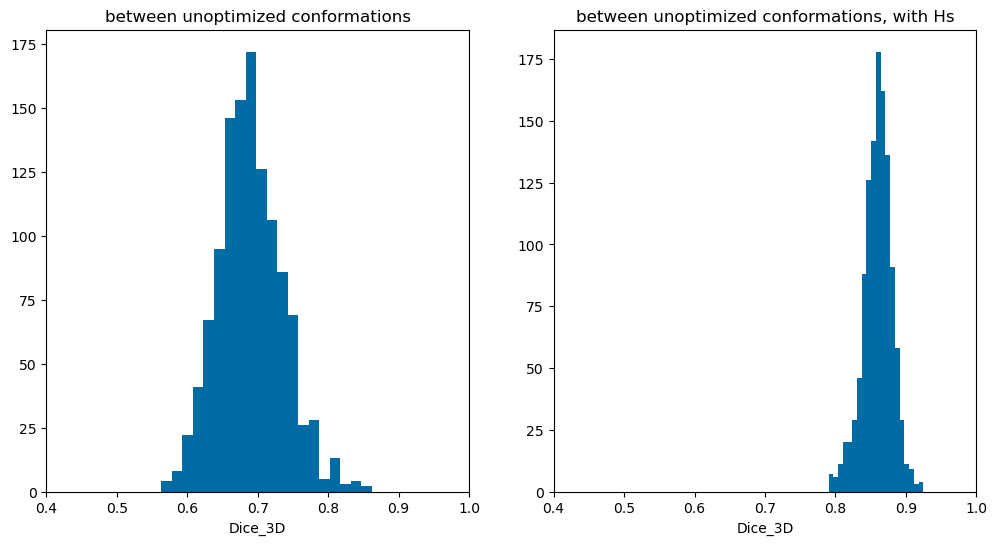

In [210]:
figsize(12,6)
subplot(1,2,1)
hist(self3d_ds,bins=20)
xlabel('Dice_3D')
xlim(0.4,1.0)
title('between unoptimized conformations');

subplot(1,2,2)
hist(self3d_ds_h,bins=20)
xlabel('Dice_3D')
xlim(0.4,1.0)
title('between unoptimized conformations, with Hs');

Increase the minimum distance in the 3D fps

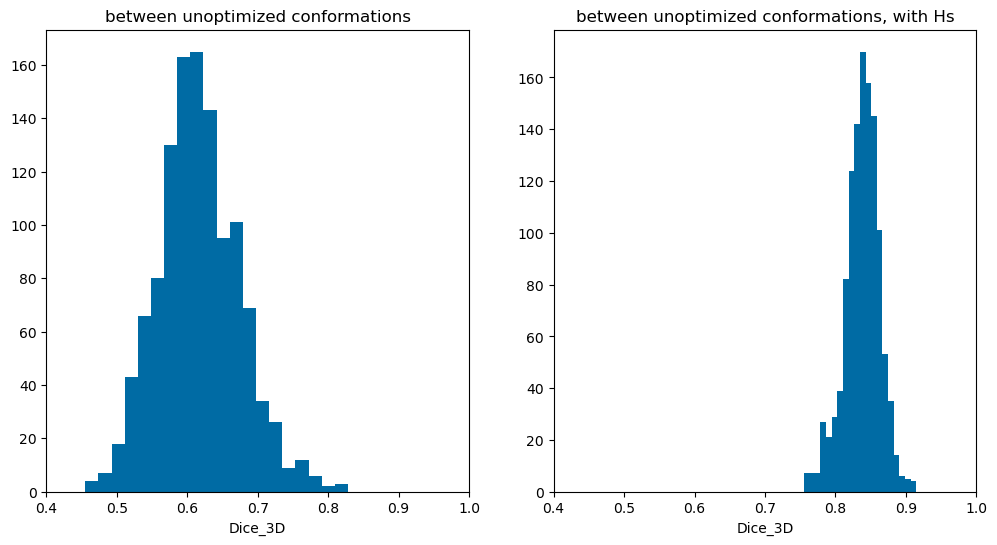

In [212]:
fpg_3 = rdFingerprintGenerator.GetAtomPairGenerator(use2D=False,minDistance=3)
self_fps2 = [fpg_3.GetCountFingerprint(x) for x in flex_mols]
self_fps2_h = [fpg_3.GetCountFingerprint(x) for x in flex_mols_h]
self3d_ds2 = []
self3d_ds2_h = []
for i in range(len(self_fps2)):
    self3d_ds2.extend(DataStructs.BulkDiceSimilarity(self_fps2[i],self_fps2[i+1:]))
    self3d_ds2_h.extend(DataStructs.BulkDiceSimilarity(self_fps2_h[i],self_fps2_h[i+1:]))
figsize(12,6)
subplot(1,2,1)
hist(self3d_ds2,bins=20)
xlabel('Dice_3D')
xlim(0.4,1.0)
title('between unoptimized conformations');

subplot(1,2,2)
hist(self3d_ds2_h,bins=20)
xlabel('Dice_3D')
xlim(0.4,1.0)
title('between unoptimized conformations, with Hs');

Optimizing the structures results in a bit less diversity, as expected:

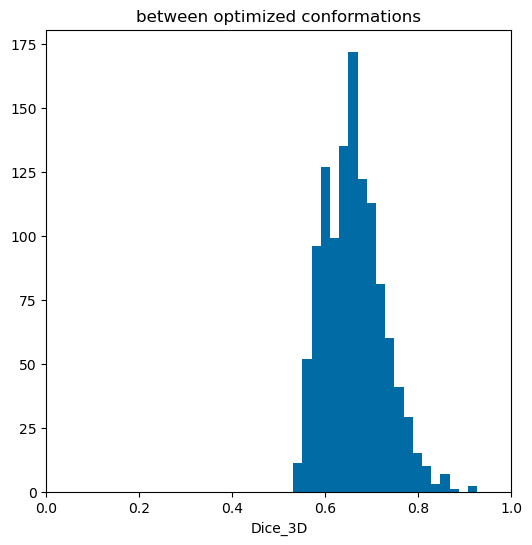

In [175]:
opt_mols=[]
tmol = Chem.Mol(flex_mol)
AllChem.MMFFOptimizeMoleculeConfs(tmol,numThreads=4)
for cid in cids:
    tmol2 = Chem.Mol(tmol)
    for tcid in cids:
        if tcid==cid:
            continue
        tmol2.RemoveConformer(tcid)
    opt_mols.append(Chem.RemoveHs(tmol2))
self_fps = [fpg.GetCountFingerprint(x) for x in opt_mols]
self3d_ds = []
for i in range(len(self_fps)):
    self3d_ds.extend(DataStructs.BulkDiceSimilarity(self_fps[i],self_fps[i+1:]))
hist(self3d_ds,bins=20)
xlabel('Dice_3D')
xlim(0,1.0)

title('between optimized conformations');

That's not a huge amount of variability. The median similarity is above 0.9

There is some correlation, but it's not super strong.

# impact of the min dist on 2D similarity

fxa spearman R: 0.932
dpp4 spearman R: 0.949
cdk2 spearman R: 0.977
hs90a spearman R: 0.969
mk14 spearman R: 0.965


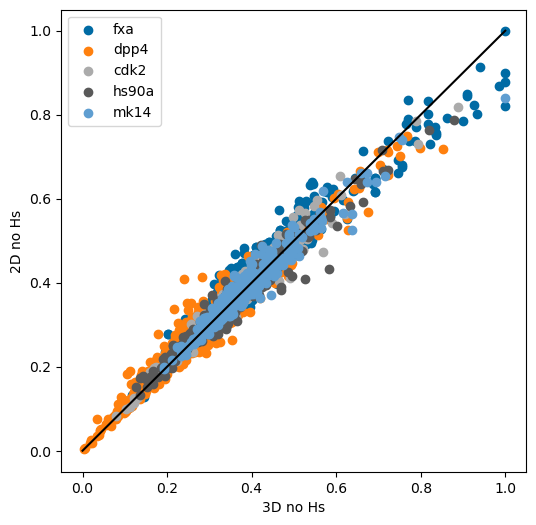

In [211]:
from scipy import stats
figsize(6,6)
for k1,v1 in sims.items():
    v2 = sims_2d[k1]
    scatter(v2,v1,label=k1)
    print(f'{k1} spearman R: {stats.spearmanr(v1,v2)[0]:.3f}')
xlabel('3D no Hs')
ylabel('2D no Hs')
plot((0,1),(0,1),'k-')
legend();

fxa spearman R: 0.903
dpp4 spearman R: 0.906
cdk2 spearman R: 0.931
hs90a spearman R: 0.939
mk14 spearman R: 0.928


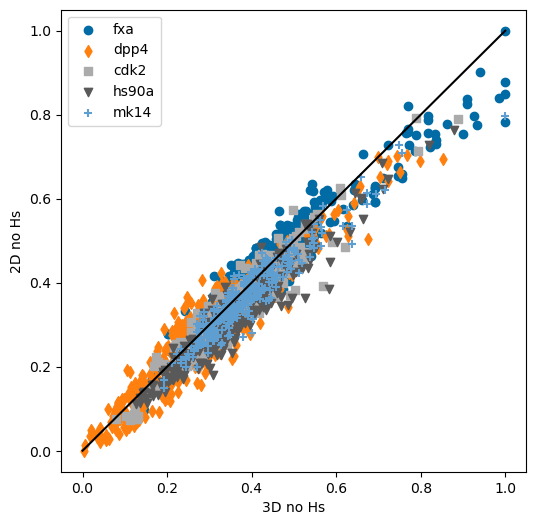

In [224]:
fpg_3 = rdFingerprintGenerator.GetAtomPairGenerator(use2D=False,minDistance=3)
fps2 = {k:[fpg_3.GetCountFingerprint(x) for x in y] for k,y in mols.items()}
fps2_h = {k:[fpg_3.GetCountFingerprint(x) for x in y] for k,y in mols_h.items()}
sims_ds2 = {}
sims_ds2_h = {}
for k in fps2:
    tfps = fps2[k]
    l = []
    for i in range(len(tfps)):
        l.extend(DataStructs.BulkDiceSimilarity(tfps[i],tfps[i+1:]))
    sims_ds2[k] = l
    
    tfps = fps2_h[k]
    l = []
    for i in range(len(tfps)):
        l.extend(DataStructs.BulkDiceSimilarity(tfps[i],tfps[i+1:]))
    sims_ds2_h[k] = l
    
    

figsize(6,6)
markers = ('o','d','s','v','+','x')
for i,(k1,v1) in enumerate(sims_ds2.items()):
    v2 = sims_2d[k1]
    scatter(v2,v1,label=k1,marker=markers[i%len(markers)])
    print(f'{k1} spearman R: {stats.spearmanr(v1,v2)[0]:.3f}')
xlabel('3D no Hs')
ylabel('2D no Hs')
plot((0,1),(0,1),'k-')
legend();    

fxa spearman R: 0.922
dpp4 spearman R: 0.869
cdk2 spearman R: 0.935
hs90a spearman R: 0.932
mk14 spearman R: 0.918


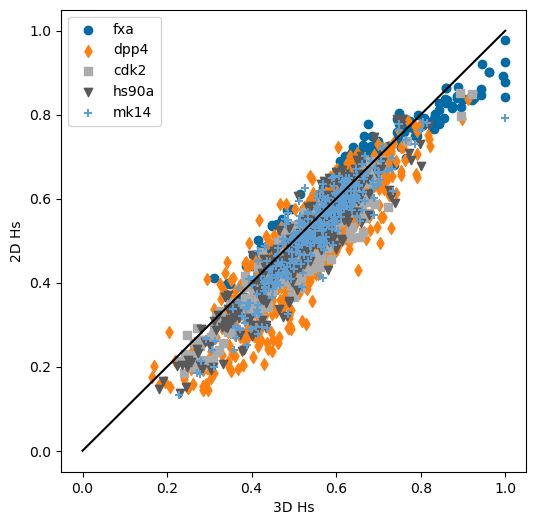

In [223]:
figsize(6,6)
markers = ('o','d','s','v','+','x')
for i,(k1,v1) in enumerate(sims_ds2_h.items()):
    v2 = sims_2d_h[k1]
    scatter(v2,v1,label=k1,marker=markers[i%len(markers)])
    print(f'{k1} spearman R: {stats.spearmanr(v1,v2)[0]:.3f}')
xlabel('3D Hs')
ylabel('2D Hs')
plot((0,1),(0,1),'k-')
legend();    

Now let's look at a comparison of 2D similarity to 3D similarity in these molecules

In [27]:
cox2_2dfps = [AllChem.GetHashedAtomPairFingerprint(x,2048) for x in cox2_ms]

In [28]:
nToDo=25000
cox2_2dds = []
random.seed(23)
while len(cox2_2dds)<nToDo:
    i = random.randint(0,len(cox2_2dfps))
    j = random.randint(0,len(cox2_2dfps))
    if j==i:
        continue
    cox2_2dds.append(DataStructs.DiceSimilarity(cox2_2dfps[i],cox2_2dfps[j]))


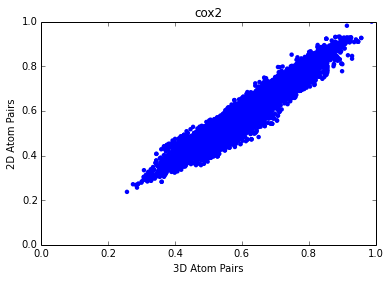

In [29]:
scatter(cox2_ds,cox2_2dds,edgecolors='none')
xlabel('3D Atom Pairs')
ylabel('2D Atom Pairs')
xlim((0,1))
ylim((0,1))
_=title('cox2')

In [30]:
from scipy import stats

pearson_r,pearson_p = stats.pearsonr(cox2_ds,cox2_2dds)
print 'Pearson R: %.3f'%pearson_r

Pearson R: 0.968


Somehow not completely surprising...

Repeat that for the thrombin compounds:

Pearson R: 0.982


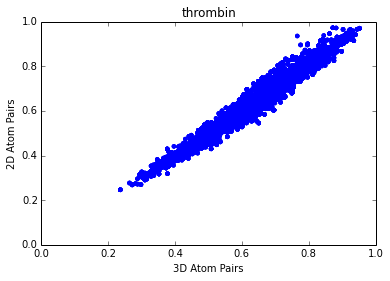

In [32]:
thr_2dfps = [rdMolDescriptors.GetHashedAtomPairFingerprint(x,2048) for x in thr_ms]
nToDo=25000
thr_2dds = []
random.seed(23)
while len(thr_2dds)<nToDo:
    i = random.randint(0,len(thr_2dfps))
    j = random.randint(0,len(thr_2dfps))
    if j==i:
        continue
    thr_2dds.append(DataStructs.DiceSimilarity(thr_2dfps[i],thr_2dfps[j]))
scatter(thr_ds,thr_2dds,edgecolors='none')
xlabel('3D Atom Pairs')
ylabel('2D Atom Pairs')
xlim((0,1))
ylim((0,1))
_=title('thrombin')
pearson_r,pearson_p = stats.pearsonr(thr_ds,thr_2dds)
print 'Pearson R: %.3f'%pearson_r

Same story here: very high correlation between the 2D and 3D similarity

Look at the deltas:

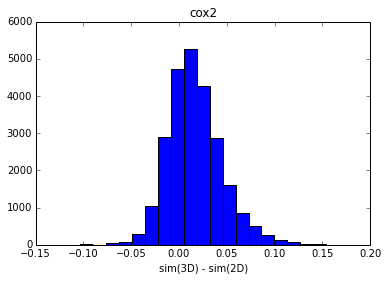

In [35]:
dcox2 = [x-y for x,y in zip(cox2_ds,cox2_2dds)]
_=hist(dcox2,bins=20)
xlabel('sim(3D) - sim(2D)')
_=title('cox2')


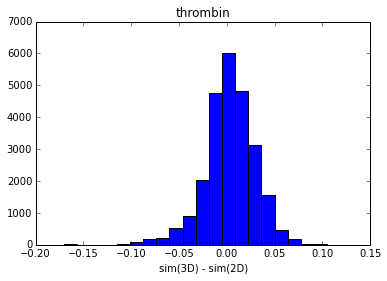

In [36]:
dthr = [x-y for x,y in zip(thr_ds,thr_2dds)]
_=hist(dthr,bins=20)
xlabel('sim(3D) - sim(2D)')
_=title('thrombin')


# Diversity set

Now let's try a larger set of more diverse molecules. Use the similarity comparison set we've used before.

In [4]:
# we're going to use 3d structures, so we want to do salt stripping
from rdkit.Chem import SaltRemover
sr = SaltRemover.SaltRemover()
rows=[]
metals = Chem.MolFromSmarts('[!#5;!#6;!#7;!#8;!#9;!#14;!#15;!#16;!#17;!#34;!#35;!#53]')
for row in gzip.open('../data/chembl16_25K.pairs.txt.gz').readlines():
    row = row.split()
    row[1] = sr(Chem.MolFromSmiles(row[1]))
    if row[1] is not None and row[1].HasSubstructMatch(metals):
        row[1] = None
    row[3] = sr(Chem.MolFromSmiles(row[3]))
    if row[3] is not None and row[3].HasSubstructMatch(metals):
        row[3] = None
    rows.append(row)

Generate a single conformation for each molecule.

We use the ipython parallel execution code for this time-consuming, but embarassingly parallel process.

In [5]:
from IPython.parallel import Client
rc = Client()
dview = rc[:]


In [6]:
with dview.sync_imports():
    from rdkit import Chem
    from rdkit.Chem import AllChem
    def addcoords(row):
        if row[1] is None or row[3] is None:
            return row
        if row[1].GetNumAtoms():
            m = Chem.AddHs(row[1])
            cid = AllChem.EmbedMolecule(m)
            if cid<0:
                cid = AllChem.EmbedMolecule(m,useRandomCoords=True)
        else:
            m = None
        row[1]=m
        if row[3].GetNumAtoms():
            m = Chem.AddHs(row[3])
            cid = AllChem.EmbedMolecule(m)
            if cid<0:
                cid = AllChem.EmbedMolecule(m,useRandomCoords=True)
        else:
            m = None
        row[3]=m
        return row
    def optcoords(row):
        if row[1] is None or row[3] is None:
            return row
        m = row[1]
        if m is not None and m.GetNumConformers()!=0:
            AllChem.UFFOptimizeMolecule(m,maxIters=10)
            m1 = AllChem.RemoveHs(m)
            row[1]=m1

        m = row[3]
        if m is not None and m.GetNumConformers()!=0:
            AllChem.UFFOptimizeMolecule(m,maxIters=10)
            m2 = AllChem.RemoveHs(m)
            row[3]=m2
        return row
        

importing Chem from rdkit on engine(s)
importing AllChem from rdkit.Chem on engine(s)


In [7]:
nrows = dview.map_sync(addcoords,rows)

In [8]:
rows = nrows
import cPickle
outf=gzip.open('../data/chembl16_25K.pairs.3dmols.pkl.gz','wb+')
cPickle.dump(rows,outf,2)

And now optimize those conformations and remove the Hs we added to generate coords

In [9]:
nrows=None
nrows = dview.map_sync(optcoords,rows)

In [10]:
rows = nrows
nrows=None
outf=gzip.open('../data/chembl16_25K.pairs.3dmols.pkl.gz','wb+')
cPickle.dump(rows,outf,2)

In [11]:
len([1 for x in rows if x[1] is not None and x[3] is not None])

24954

In [20]:
rows=None
rows = cPickle.load(gzip.open('../data/chembl16_25K.pairs.3dmols.pkl.gz'))


Next step: we need to assign stereo codes based on the 3D structures we have; otherwise the chirality-using atom pairs will get super confused

In [12]:
for row in rows:
    if row[1] is None or row[3] is None:
        continue
    Chem.AssignAtomChiralTagsFromStructure(row[1])
    Chem.AssignStereochemistry(row[1],force=True)
    Chem.AssignAtomChiralTagsFromStructure(row[3])
    Chem.AssignStereochemistry(row[3],force=True)


In [14]:
div_2dfps =None
sims2d = []
sims3d = []
dindices=[]
for i,x in enumerate(rows):
    if x[1] is None or x[3] is None:
        continue
    try:
        s3 = DataStructs.DiceSimilarity(rdMolDescriptors.GetHashedAtomPairFingerprint(x[1],2048,use2D=False),\
              rdMolDescriptors.GetHashedAtomPairFingerprint(x[3],2048,use2D=False))
    except:
        continue
    s2 = DataStructs.DiceSimilarity(rdMolDescriptors.GetHashedAtomPairFingerprint(x[1],2048,includeChirality=True),\
              rdMolDescriptors.GetHashedAtomPairFingerprint(x[3],2048,includeChirality=True))
    sims2d.append(s2)
    sims3d.append(s3)
    dindices.append(i)
    # clear out the cached distance matrices to save memory
    if x[1].HasProp('DistanceMatrix'): 
        x[1].ClearProp('DistanceMatrix')
        x[1].ClearProp('DistanceMatrix_Paths')
    if x[1].HasProp('_3DDistanceMatrix_Conf0'): 
        x[1].ClearProp('_3DDistanceMatrix_Conf0')
    if x[3].HasProp('DistanceMatrix'): 
        x[3].ClearProp('DistanceMatrix')
        x[3].ClearProp('DistanceMatrix_Paths')
    if x[3].HasProp('_3DDistanceMatrix_Conf0'): 
        x[3].ClearProp('_3DDistanceMatrix_Conf0')
        


Pearson R: 0.897


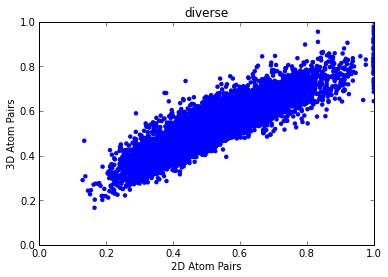

In [15]:
from scipy import stats

scatter(sims2d,sims3d,edgecolors='none')
xlabel('2D Atom Pairs')
ylabel('3D Atom Pairs')
xlim((0,1))
ylim((0,1))
_=title('diverse')
pearson_r,pearson_p = stats.pearsonr(sims2d,sims3d)
print 'Pearson R: %.3f'%pearson_r

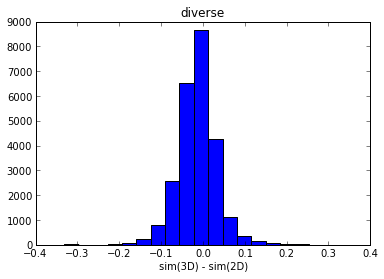

In [16]:
dsim = [x-y for x,y in zip(sims2d,sims3d)]
_=hist(dsim,bins=20)
xlabel('sim(3D) - sim(2D)')
_=title('diverse')


Let's look at the pairs that have a much higher 2D similarity than 3D similarity

In [17]:
pairs1 = [x for x,y in enumerate(sims2d) if y>0.95 and sims3d[x]<0.8]
print len(pairs1)

17


In [19]:
toShow=[]
lbls=[]
for idx in pairs1:
    did=dindices[idx]
    print did,sims2d[idx],sims3d[idx]
    toShow.append(rows[did][1])
    toShow.append(rows[did][3])
    lbls.append('Sim2d: %.2f'%sims2d[idx])
    lbls.append('Sim3d: %.2f'%sims3d[idx])

1412 1.0 0.766233766234
1846 1.0 0.786764705882
3534 1.0 0.777777777778
8909 1.0 0.766666666667
10503 0.96835443038 0.648514851485
11229 1.0 0.711693548387
12381 1.0 0.701058201058
13774 1.0 0.730994152047
14329 1.0 0.775362318841
16569 1.0 0.773399014778
17107 1.0 0.724137931034
17755 1.0 0.684729064039
17976 1.0 0.64367816092
19966 1.0 0.742424242424
24086 1.0 0.769230769231
24211 1.0 0.795566502463
24901 1.0 0.733333333333


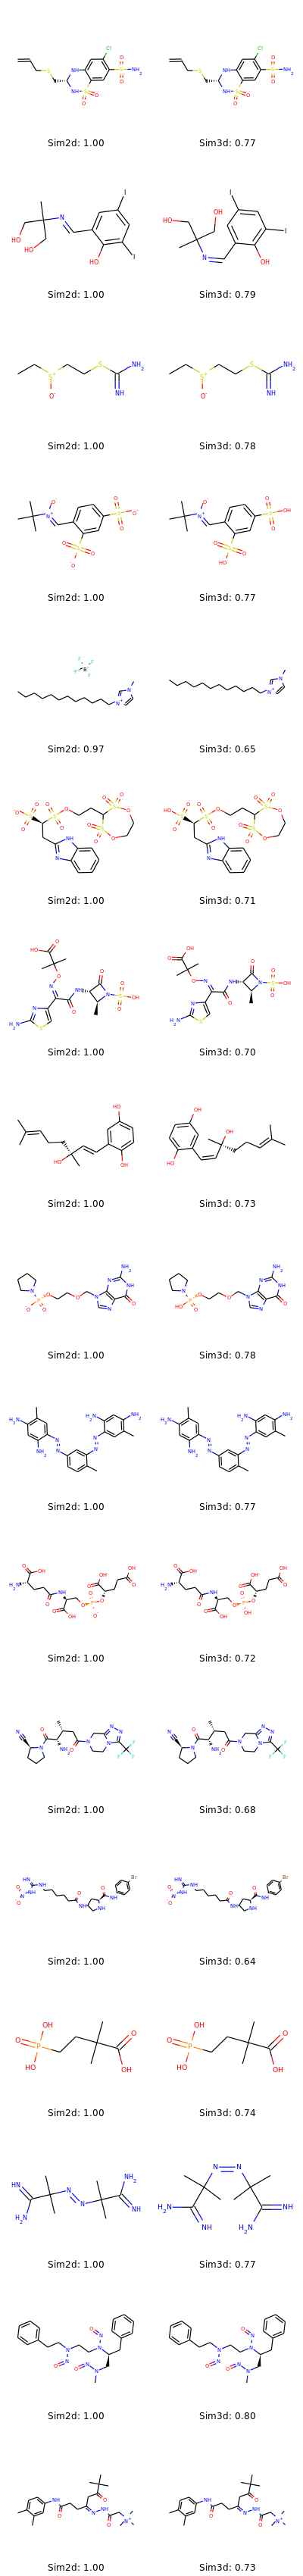

In [22]:
Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(x,True)) for x in toShow],molsPerRow=2,legends=lbls)

What about pairs where the 3D similarity is higher?

In [25]:
pairs2 = [x for x,y in enumerate(sims3d) if y>0.7 and y-sims2d[x]>.15]
print len(pairs2)

8


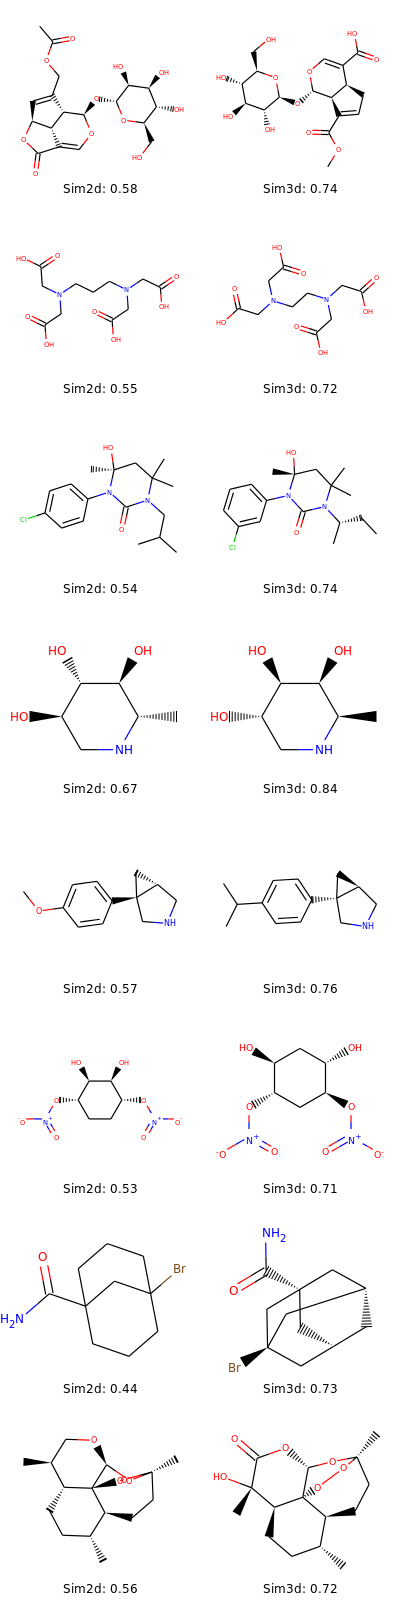

In [28]:
toShow=[]
lbls=[]
for idx in pairs2:
    did=dindices[idx]
    toShow.append(rows[did][1])
    toShow.append(rows[did][3])
    lbls.append('Sim2d: %.2f'%sims2d[idx])
    lbls.append('Sim3d: %.2f'%sims3d[idx])
Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(x,True)) for x in toShow],molsPerRow=2,legends=lbls)

In [38]:
DataStructs.DiceSimilarity(rdMolDescriptors.GetHashedAtomPairFingerprint(rows[24211][1],2048,includeChirality=True),\
              rdMolDescriptors.GetHashedAtomPairFingerprint(rows[24211][3],2048,includeChirality=True))

1.0

In [40]:
maxrot=[]
for rowid in dindices:
    maxrot.append(max(rdMolDescriptors.CalcNumRotatableBonds(rows[rowid][1]),\
                      rdMolDescriptors.CalcNumRotatableBonds(rows[rowid][3])))



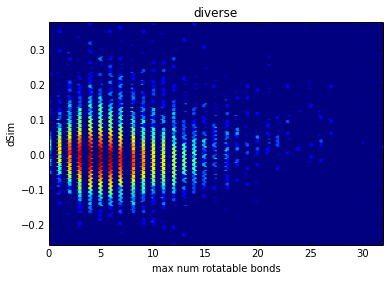

In [43]:
hexbin(maxrot,dsim,edgecolors='none',bins='log')
xlabel('max num rotatable bonds')
ylabel('dSim')
_=title('diverse')

In [53]:
[(i,z,x,y) for i,(x,y,z) in enumerate(zip(dsim,maxrot,dindices)) if y==1 and abs(x)>0.1]

[(957, 957, 0.11080332409972293, 1),
 (2870, 2871, 0.10869565217391308, 1),
 (2950, 2951, 0.12, 1),
 (3262, 3263, 0.15339233038348077, 1),
 (4246, 4247, 0.10495626822157439, 1),
 (4606, 4607, 0.18000000000000005, 1),
 (4913, 4916, 0.15625, 1),
 (6586, 6589, 0.1333333333333333, 1),
 (8435, 8439, 0.12483652743917206, 1),
 (10412, 10417, 0.1199538638985006, 1),
 (11013, 11018, 0.10389610389610382, 1),
 (11363, 11368, 0.10483870967741937, 1),
 (11515, 11520, 0.12903225806451613, 1),
 (11590, 11595, 0.10457516339869277, 1),
 (11759, 11764, -0.10526315789473684, 1),
 (12075, 12080, 0.23809523809523803, 1),
 (12180, 12185, 0.10236220472440949, 1),
 (12764, 12769, 0.3557692307692307, 1),
 (14313, 14318, -0.109375, 1),
 (14464, 14469, -0.13999999999999996, 1),
 (18887, 18892, 0.2976026570048309, 1),
 (19075, 19080, 0.17174515235457066, 1),
 (19565, 19570, -0.10909090909090913, 1),
 (20085, 20090, 0.10121899957965541, 1),
 (20722, 20727, 0.10989010989010994, 1),
 (20920, 20925, 0.120300751879699

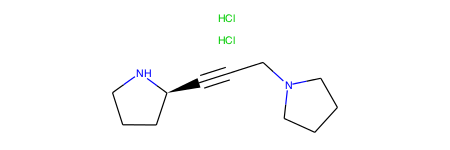

In [49]:
Chem.MolFromSmiles(Chem.MolToSmiles(rows[12769][1],True))

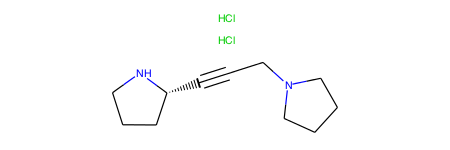

In [50]:
Chem.MolFromSmiles(Chem.MolToSmiles(rows[12769][3],True))

In [54]:
sims2d[12764],sims3d[12764]

(1.0, 0.6442307692307693)

In [67]:
Chem.AssignStereochemistry(rows[12769][1])
Chem.AssignStereochemistry(rows[12769][3])


In [68]:
DataStructs.DiceSimilarity(rdMolDescriptors.GetHashedAtomPairFingerprint(rows[12769][1],2048,includeChirality=True),\
              rdMolDescriptors.GetHashedAtomPairFingerprint(rows[12769][3],2048,includeChirality=True))

0.8461538461538461

In [69]:
for row in rows:
    Chem.AssignStereochemistry(row[1])
    Chem.AssignStereochemistry(row[3])

In [70]:
sims2d = []
sims3d = []
dindices=[]
for i,x in enumerate(rows):
    if row is None:
        continue
    try:
        s3 = DataStructs.DiceSimilarity(rdMolDescriptors.GetHashedAtomPairFingerprint(x[1],2048,use2D=False),\
              rdMolDescriptors.GetHashedAtomPairFingerprint(x[3],2048,use2D=False))
    except:
        continue
    s2 = DataStructs.DiceSimilarity(rdMolDescriptors.GetHashedAtomPairFingerprint(x[1],2048,includeChirality=True),\
              rdMolDescriptors.GetHashedAtomPairFingerprint(x[3],2048,includeChirality=True))
    sims2d.append(s2)
    sims3d.append(s3)
    dindices.append(i)
    # clear out the cached distance matrices to save memory
    if x[1].HasProp('DistanceMatrix'): 
        x[1].ClearProp('DistanceMatrix')
        x[1].ClearProp('DistanceMatrix_Paths')
    if x[1].HasProp('_3DDistanceMatrix_Conf0'): 
        x[1].ClearProp('_3DDistanceMatrix_Conf0')
    if x[3].HasProp('DistanceMatrix'): 
        x[3].ClearProp('DistanceMatrix')
        x[3].ClearProp('DistanceMatrix_Paths')
    if x[3].HasProp('_3DDistanceMatrix_Conf0'): 
        x[3].ClearProp('_3DDistanceMatrix_Conf0')
        


Pearson R: 0.839


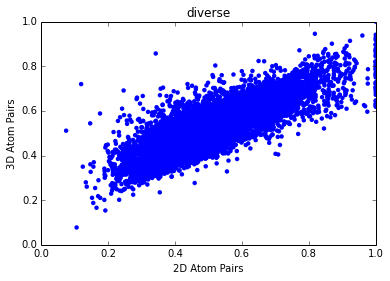

In [71]:
scatter(sims2d,sims3d,edgecolors='none')
xlabel('2D Atom Pairs')
ylabel('3D Atom Pairs')
xlim((0,1))
ylim((0,1))
_=title('diverse')
pearson_r,pearson_p = stats.pearsonr(sims2d,sims3d)
print 'Pearson R: %.3f'%pearson_r

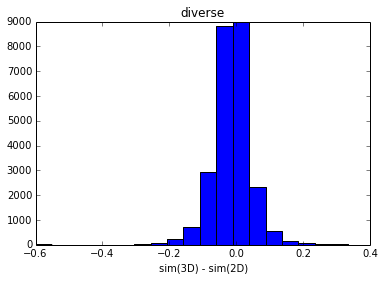

In [72]:
dsim = [x-y for x,y in zip(sims2d,sims3d)]
_=hist(dsim,bins=20)
xlabel('sim(3D) - sim(2D)')
_=title('diverse')


In [79]:
diffs=sorted([(i,z,x,y) for i,(x,y,z) in enumerate(zip(dsim,maxrot,dindices)) if y==1 and abs(x)>0.1],key=lambda x:x[2])
diffs

[(10450, 10455, -0.6, 1),
 (6910, 6913, -0.37259100642398285, 1),
 (16204, 16209, -0.2915451895043732, 1),
 (16260, 16265, -0.2637362637362638, 1),
 (9642, 9646, -0.256, 1),
 (7159, 7162, -0.2341597796143251, 1),
 (11570, 11575, -0.21999999999999997, 1),
 (17335, 17340, -0.2113821138211382, 1),
 (7273, 7276, -0.20512820512820507, 1),
 (9745, 9749, -0.203125, 1),
 (1580, 1581, -0.20118343195266264, 1),
 (24057, 24062, -0.19825072886297374, 1),
 (10645, 10650, -0.19493670886075948, 1),
 (15633, 15638, -0.19002375296912116, 1),
 (21178, 21183, -0.18954248366013074, 1),
 (18581, 18586, -0.1889763779527559, 1),
 (6751, 6754, -0.18538324420677366, 1),
 (2157, 2158, -0.18055555555555558, 1),
 (12366, 12371, -0.18045112781954886, 1),
 (23035, 23040, -0.17910447761194032, 1),
 (736, 736, -0.17821782178217827, 1),
 (7839, 7843, -0.1730103806228374, 1),
 (1364, 1365, -0.1677419354838709, 1),
 (6085, 6088, -0.16666666666666669, 1),
 (2254, 2255, -0.16279069767441856, 1),
 (23842, 23847, -0.1611374

Take a look at a few molecules where the 3D similarity is a lot higher than the 2D similarity

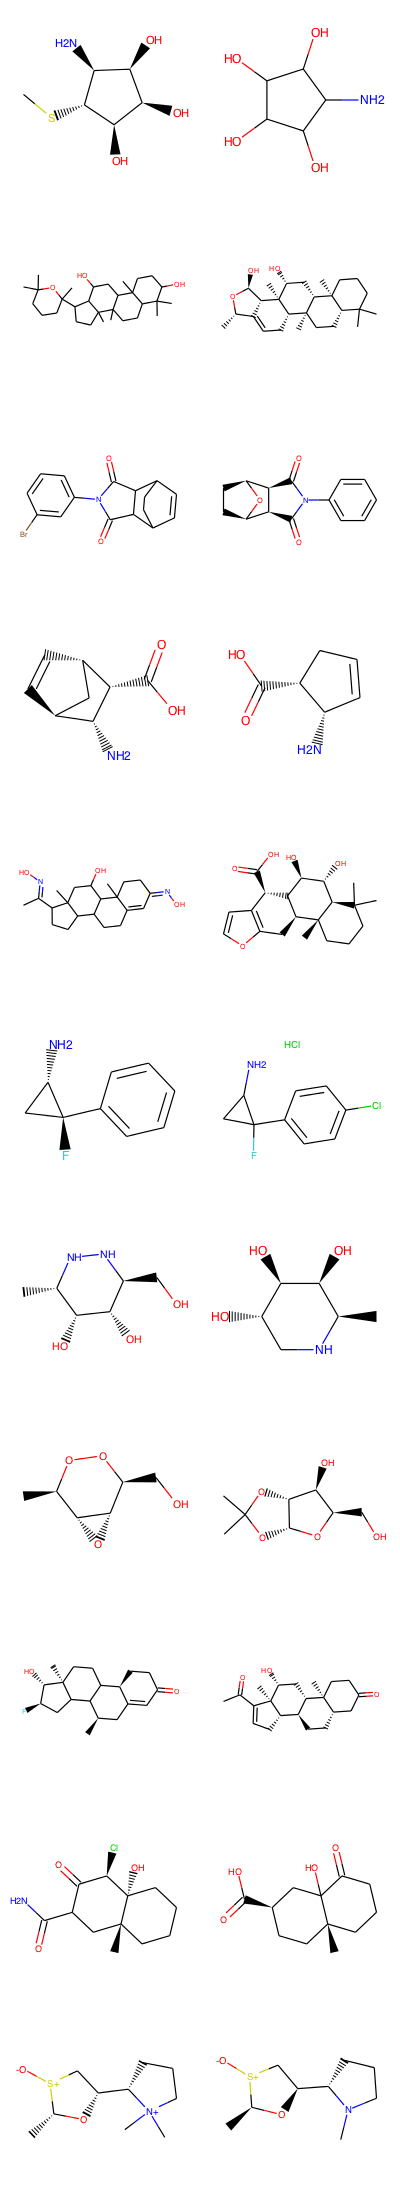

In [81]:
tms=[]
for drow in diffs:
    if drow[2]<=-0.2:
        tms.append(Chem.MolFromSmiles(Chem.MolToSmiles(rows[drow[1]][1],True)))
        tms.append(Chem.MolFromSmiles(Chem.MolToSmiles(rows[drow[1]][3],True)))
Draw.MolsToGridImage(tms,molsPerRow=2)

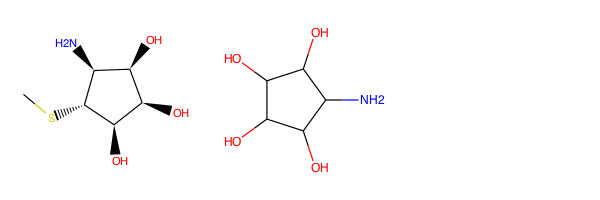

In [76]:
id_ = 10455
Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(rows[id_][1],True)),\
                      Chem.MolFromSmiles(Chem.MolToSmiles(rows[id_][3],True))])

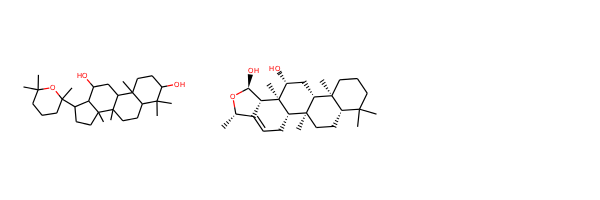

In [77]:
id_ = 6913
Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(rows[id_][1],True)),\
                      Chem.MolFromSmiles(Chem.MolToSmiles(rows[id_][3],True))])

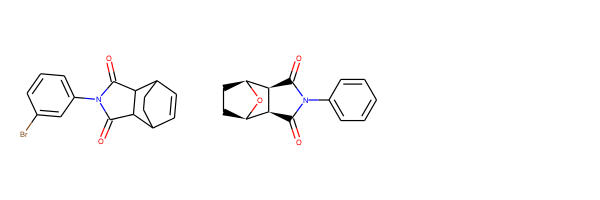

In [78]:
id_ = 16209
Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(rows[id_][1],True)),\
                      Chem.MolFromSmiles(Chem.MolToSmiles(rows[id_][3],True))])